In [1]:
import numpy as np
import scipy
import quantarhei as qr
from quantarhei import Molecule, Aggregate,DFunction
from quantarhei import CorrelationFunction
from quantarhei import TimeAxis
from quantarhei import convert,energy_units
from quantarhei.qm.liouvillespace.rates.modifiedredfieldrates import ModifiedRedfieldRateMatrix

from matplotlib import pyplot as plt

from quantarhei.core.units import kB_int

In [2]:
def _c2g(timeaxis,coft):
    """ Converts correlation function to lineshape function

    Explicit numerical double integration of the correlation
    function to form a lineshape function.

    Parameters
    ----------

    timeaxis : cu.oqs.time.TimeAxis
        TimeAxis of the correlation function

    coft : complex numpy array
        Values of correlation function given at points specified
        in the TimeAxis object


    """

    ta = timeaxis
    rr = np.real(coft)
    ri = np.imag(coft)
    sr = scipy.interpolate.UnivariateSpline(ta.data,
                        rr,s=0).antiderivative()(ta.data)
    sr = scipy.interpolate.UnivariateSpline(ta.data,
                        sr,s=0).antiderivative()(ta.data)
    si = scipy.interpolate.UnivariateSpline(ta.data,
                        ri,s=0).antiderivative()(ta.data)
    si = scipy.interpolate.UnivariateSpline(ta.data,
                        si,s=0).antiderivative()(ta.data)
    gt = sr + 1j*si
    return gt

def _c2h(timeaxis,coft):
    """ Converts correlation function to derivative of lineshape function

    Explicit numerical single integration of the correlation
    function to form a time redivative of lineshape function.

    Parameters
    ----------

    timeaxis : cu.oqs.time.TimeAxis
        TimeAxis of the correlation function

    coft : complex numpy array
        Values of correlation function given at points specified
        in the TimeAxis object


    """

    ta = timeaxis
    rr = np.real(coft)
    ri = np.imag(coft)
    sr = scipy.interpolate.UnivariateSpline(ta.data,
                        rr,s=0).antiderivative()(ta.data)
    si = scipy.interpolate.UnivariateSpline(ta.data,
                        ri,s=0).antiderivative()(ta.data)
    ht = sr + 1j*si
    return ht

In [3]:
def get_modified_Redfield_rate(aggreg,force_detbalance=True):
    time = aggreg.sbi.TimeAxis
    
    time_full = np.zeros(time._length*2)
    time_full[time._length:] = time.data.copy()
    time_full[1:time._length] = -time.data[:0:-1]
    time_full[0] = time_full[1] - time.step


    # fill the corr. matrix 
    Cmat = np.zeros((aggreg.Ntot,time._length),dtype=np.complex128)
    lambdas = np.zeros(aggreg.Ntot,dtype=np.float64)
    for ii in range(aggreg.Ntot):
        Cmat[ii,:] = aggreg.sbi.get_coft(ii,ii)
    for ii in range(aggreg.Nb[1]):
        lambdas[ii+1] = aggreg.sbi.get_reorganization_energy(ii)

    # Rate matrix init
    KK = np.zeros((aggreg.Ntot,aggreg.Ntot),dtype=np.float64)
    
    SS = aggreg.SS.copy()

    
    for M in range(aggreg.Ntot):
        if force_detbalance:
            minL = M+1
        else:
            minL=0
        for L in range(minL,aggreg.Ntot):
            if M==L:
                continue
            # Here we assume noncorrelated sites (diagonal correlation function matrix)
            # prepare individual quantities
            cMMMM = np.dot(SS[:,M]**4,Cmat)
            cLLLL = np.dot(SS[:,L]**4,Cmat)
            cMLLL = np.dot((SS[:,L]**3)*SS[:,M],Cmat)
            cMMML = np.dot((SS[:,M]**3)*SS[:,L],Cmat)
            cMMLL = np.dot((SS[:,M]**2)*(SS[:,L]**2),Cmat)

            gMMMM = _c2g(time,cMMMM)
            gLLLL = _c2g(time,cLLLL)
            gMMLL = _c2g(time,cMMLL)

            hMLLL = _c2h(time,cMLLL)
            hMMML = _c2h(time,cMMML)

            lambdaLLLL = np.dot(SS[:,L]**4,lambdas)
            lambdaMMLL = np.dot((SS[:,M]**2)*(SS[:,L]**2),lambdas)
            lambdaMLLL = np.dot(SS[:,M]*(SS[:,L]**3),lambdas)

            omML = aggreg.HH[L,L]-aggreg.HH[M,M]

            # Compute rates (time dependent function)
            om = omML-2*lambdaLLLL+2*lambdaMMLL
            ft_full = np.zeros(time._length*2,dtype=np.complex128)
            ft = np.exp(- gLLLL - gMMMM + 2*gMMLL)
            ft *= (cMMLL - (hMLLL - hMMML + 2*1j*lambdaMLLL)**2 )

            # Replace the time integration over very oscillating function by the fourier transform
            # Prepare the negative part of the function - because we want the real part of the positive
            # part of the function the negative has to be the complex conjugate and we get exactly what
            # we need\
            ft_full[time._length:] = ft.copy()
            ft_full[1:time._length] = np.conj(ft[:0:-1])
            # Perform the fourier transform
            fw_full = 2*time.length*np.fft.fftshift(np.fft.ifft(np.fft.fftshift(ft_full)))*time.step
            fw_full = np.real(fw_full)
            faxis = time.get_FrequencyAxis()
            # Define the result as DFunction to enable the interpolation
            Fw = DFunction(x=faxis,y=fw_full)
            
            KK[M,L] = Fw.at(om)
    
    if force_detbalance:
        T = aggreg.sbi.get_temperature()
        for M in range(aggreg.Ntot):
            for L in range(M+1,aggreg.Ntot):
                if M==L:
                    continue
                
                om00 = aggreg.HH[M,M]-aggreg.HH[L,L] + np.dot(SS[:,L]**4,lambdas) - np.dot(SS[:,M]**4,lambdas)
                
                KK[L,M] = KK[M,L] * np.exp(om00/kB_int/T)
        
    return KK

In [4]:
# Define correlation function for the chlorophylls
#-----------------------------------------------------------#
with energy_units("1/cm"):
    time = TimeAxis(0.0, 30000, 0.3) # time axis for correlation function
    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/convert(30,"1/cm","int")
    reorg_eng = 60 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfce = CorrelationFunction(time,cfce_params)

    # High frequency part of the correlation function
    nm = [[250,0.06],[300,0.04],[375,0.06],
        [500,0.04],[600,0.015],[725,0.04],[800,0.02],[875,0.02]]

    nm = np.array(nm,dtype="f8")
    omega = nm[:,0] # cm-1
    lamb = nm[:,0]*nm[:,1] #cm-1
    gamma = 5.0 #cm-1


    for ii in range(nm.shape[0]):
        cfce_params2 = dict(ftype="UnderdampedBrownian",
                   reorg = lamb[ii], #reorg_vib1,
                   gamma = gamma, #gamma1,
                   freq = omega[ii], #vib1_freq,
                   T=Temp)
        cfce2 = CorrelationFunction(time,cfce_params2)
        cfce.__iadd__(cfce2)

In [5]:
# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = Molecule(name="Molecule1",elenergies=[0,[1.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = Molecule(name="Molecule2",elenergies=[0,[1.0]])
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
aggreg.set_resonance_coupling(0,1,0.01)

aggreg.build(mult=1,sbi_for_higher_ex=False)

0 -1 0 0
1 0 1 1
2 1 1 1


In [6]:
# Diagonalize the system, because the redfield works with diagonal electronic part
#------------------------------------------------------------------------#
aggreg.diagonalize()

# The transformation coefficients for the exciton states are stored in
# columns of the aggreg.SS

In [7]:
# Some small tests of the system
print("Transformation matrix into exciton states:")
print(aggreg.SS)
print("\nLength of the time axis")
print(aggreg.sbi.TimeAxis._length)
print("\nCoft of the second monomeric transition:")
print(aggreg.sbi.get_coft(2,2))
print("\nReorganization energy of site excitation (starts from zero):")
print(aggreg.sbi.get_reorganization_energy(0),cfce.get_reorganization_energy())
print("\nNumber of states in individual bands:")
print(aggreg.Nb)
print("\nExciton energy of the secodn excited state:")
print(aggreg.get_state_energy(2))

Transformation matrix into exciton states:
[[ 1.          0.          0.        ]
 [ 0.         -0.70710678  0.70710678]
 [ 0.          0.70710678  0.70710678]]

Length of the time axis
30000

Coft of the second monomeric transition:
[  4.41523996e-03 -6.38665781e-05j   4.32840342e-03 -1.68590115e-04j
   4.29338269e-03 -2.73105140e-04j ...,   2.33128814e-05 +2.44073144e-06j
   2.34065091e-05 +1.62986071e-06j   2.34627678e-05 +8.15743064e-07j]

Reorganization energy of site excitation (starts from zero):
0.0378613965029 0.0378613965029

Number of states in individual bands:
[1 2]

Exciton energy of the secodn excited state:
1.01


In [8]:
# Compute modified Redfield rate
# For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
time = aggreg.sbi.TimeAxis

time_full = np.zeros(time._length*2)
time_full[time._length:] = time.data.copy()
time_full[1:time._length] = -time.data[:0:-1]
time_full[0] = time_full[1] - time.step


# fill the corr. matrix 
Cmat = np.zeros((aggreg.Ntot,time._length),dtype=np.complex128)
lambdas = np.zeros(aggreg.Ntot,dtype=np.float64)
for ii in range(aggreg.Ntot):
    Cmat[ii,:] = aggreg.sbi.get_coft(ii,ii)
for ii in range(aggreg.Nb[1]):
    lambdas[ii+1] = aggreg.sbi.get_reorganization_energy(ii)

# State between which the rates are computed
if 1:
    M = 2
    L = 1
else:
    M = 1
    L = 2

SS = aggreg.SS.copy()

# Here we assume noncorrelated sites (diagonal correlation function matrix)
# prepare individual quantities
cMMMM = np.dot(SS[:,M]**4,Cmat)
cLLLL = np.dot(SS[:,L]**4,Cmat)
cMLLL = np.dot((SS[:,L]**3)*SS[:,M],Cmat)
cMMML = np.dot((SS[:,M]**3)*SS[:,L],Cmat)
cMMLL = np.dot((SS[:,M]**2)*(SS[:,L]**2),Cmat)

gMMMM = _c2g(time,cMMMM)
gLLLL = _c2g(time,cLLLL)
gMMLL = _c2g(time,cMMLL)

hMLLL = _c2h(time,cMLLL)
hMMML = _c2h(time,cMMML)

lambdaLLLL = np.dot(SS[:,L]**4,lambdas)
lambdaMMLL = np.dot((SS[:,M]**2)*(SS[:,L]**2),lambdas)
lambdaMLLL = np.dot(SS[:,M]*(SS[:,L]**3),lambdas)

omML = aggreg.HH[L,L]-aggreg.HH[M,M]

# Compute rates (time dependent function)
om = omML-2*lambdaLLLL+2*lambdaMMLL
ft_full = np.zeros(time._length*2,dtype=np.complex128)
ft = np.exp(- gLLLL - gMMMM + 2*gMMLL)
ft *= (cMMLL - (hMLLL - hMMML + 2*1j*lambdaMLLL)**2 )

# Replace the time integration over very oscillating function by the fourier transform
# Prepare the negative part of the function - because we want the real part of the positive
# part of the function the negative has to be the complex conjugate and we get exactly what
# we need\
ft_full[time._length:] = ft.copy()
ft_full[1:time._length] = np.conj(ft[:0:-1])
# Perform the fourier transform
fw_full = 2*time.length*np.fft.fftshift(np.fft.ifft(np.fft.fftshift(ft_full)))*time.step
fw_full = np.real(fw_full)
faxis = time.get_FrequencyAxis()
# Define the result as DFunction to enable the interpolation
Fw = DFunction(x=faxis,y=fw_full)

RMMLL = Fw.at(om)

print(RMMLL)
print(om)

lambdaMMMM = np.dot(SS[:,M]**4,lambdas)
om00 = aggreg.HH[L,L]-aggreg.HH[M,M]-lambdaLLLL+lambdaMMMM
print(aggreg.HH[L,L]-aggreg.HH[M,M]-lambdaLLLL+lambdaMMMM)

0.00919589004602
-0.02
-0.02


In [9]:
lambdas = np.zeros(aggreg.Ntot,dtype=np.float64)
for ii in range(aggreg.Nb[1]):
    lambdas[ii+1] = aggreg.sbi.get_reorganization_energy(ii)

KK = get_modified_Redfield_rate(aggreg,force_detbalance=False)
#K21 = get_modified_Redfield_rate(aggreg,2,1)

om00 = aggreg.HH[2,2]-aggreg.HH[1,1] - np.dot(SS[:,2]**4,lambdas) + np.dot(SS[:,1]**4,lambdas)

print(KK[1,2]/KK[2,1])
print(np.exp(np.abs(om00)/kB_int/Temp))

om00 = aggreg.HH[1,1]-aggreg.HH[0,0] - np.dot(SS[:,1]**4,lambdas) + np.dot(SS[:,0]**4,lambdas)

print(KK[0,1]/KK[1,0])
print(np.exp(np.abs(om00)/kB_int/Temp))
KK[0,1]

1.66367965391
1.66398529544
nan
54647935138.9


<ipython-input-9-1ce55a35dc14>:15: RuntimeWarning: invalid value encountered in double_scalars
  print(KK[0,1]/KK[1,0])


0.0

In [10]:
KK

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01529902],
       [ 0.        ,  0.00919589,  0.        ]])

In [11]:
om

-0.020000000000000018

In [12]:
Hop = aggreg.get_Hamiltonian()
mRedRates = ModifiedRedfieldRateMatrix(Hop,aggreg.sbi,aggreg.sbi.TimeAxis)
mRedRates.rates

array([[-0.        ,  0.        ,  0.        ],
       [ 0.        , -0.0091942 ,  0.01529902],
       [ 0.        ,  0.0091942 , -0.01529902]])

In [13]:
aggreg.sbi.KK

array([[[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  1.]]])

In [14]:
Fw.at(0.02)

0.015299015169209135

In [15]:
#test of the rates
Cw_even = cfce.get_EvenFTCorrelationFunction()
Cw_odd = cfce.get_OddFTCorrelationFunction()
Cw = Cw_even + Cw_odd

print(Cw.at(om)*0.5)
print(Cw.at(-om)*0.5)
print(Cw.at(om)/Cw.at(-om),np.exp(om/kB_int/Temp),om)

0.00919589004602
0.0152990151692
0.601077255256 0.600966849131 -0.02


In [16]:
print(0.00213546329443/0.000159264525319)
print(np.exp(np.abs(om00)/kB_int/Temp))

13.408279653945277
54647935138.9


In [17]:
time_full

array([-9000. , -8999.7, -8999.4, ...,  8999.1,  8999.4,  8999.7])

In [18]:
faxis.data

array([-10.47197551, -10.47162645, -10.47127738, ...,  10.47092831,
        10.47127738,  10.47162645])

In [19]:
time.data[0:][::-1]

array([  8.99970000e+03,   8.99940000e+03,   8.99910000e+03, ...,
         6.00000000e-01,   3.00000000e-01,   0.00000000e+00])

In [20]:
time.data[:0:-1]

array([  8.99970000e+03,   8.99940000e+03,   8.99910000e+03, ...,
         9.00000000e-01,   6.00000000e-01,   3.00000000e-01])

In [21]:
lambdaLLLL

0.018930698251453965

(0.0, 1000.0)

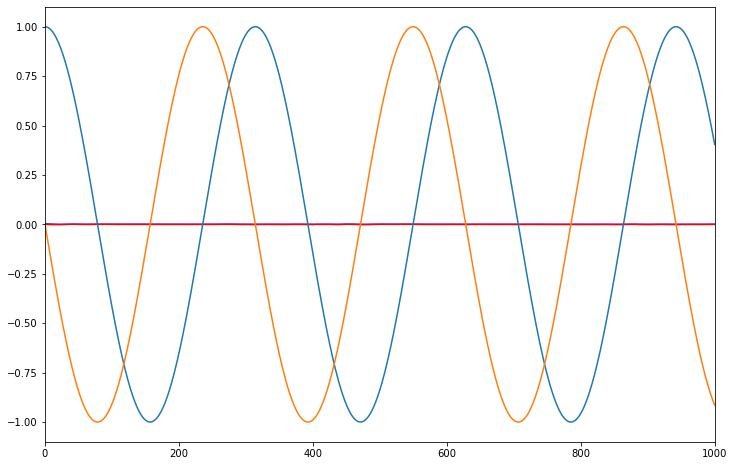

In [22]:
plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(ft),"b")
plt.plot(time.data,np.imag(ft),"r")
plt.plot(time.data,np.real(np.exp(1j*om*time.data)),"C0")
plt.plot(time.data,np.imag(np.exp(1j*om*time.data)),"C1")
plt.xlim(0,1000)


(0.0, 1000.0)

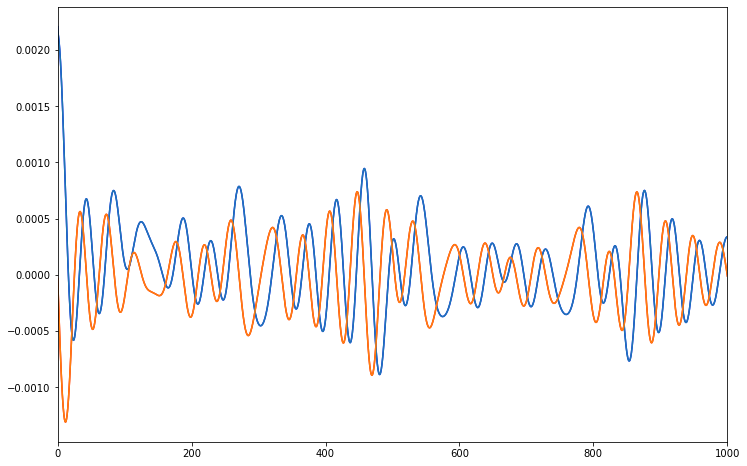

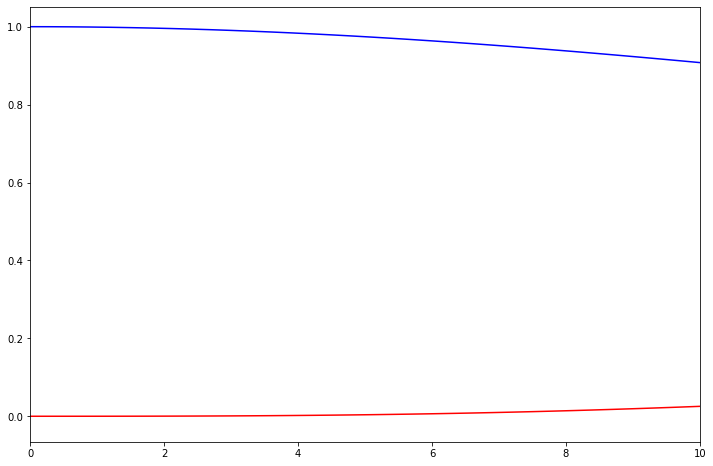

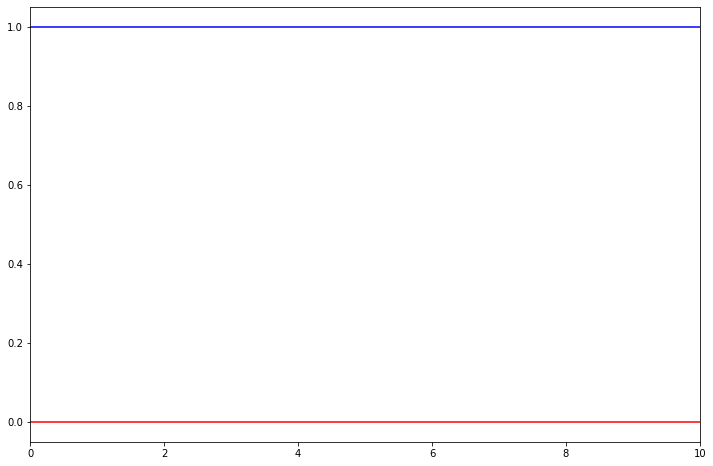

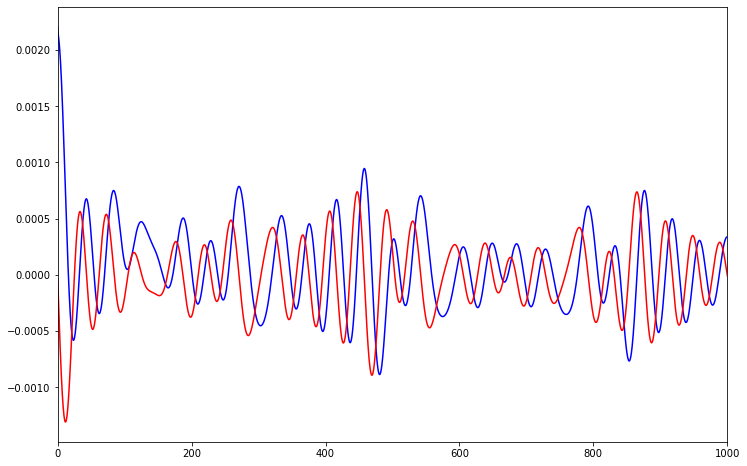

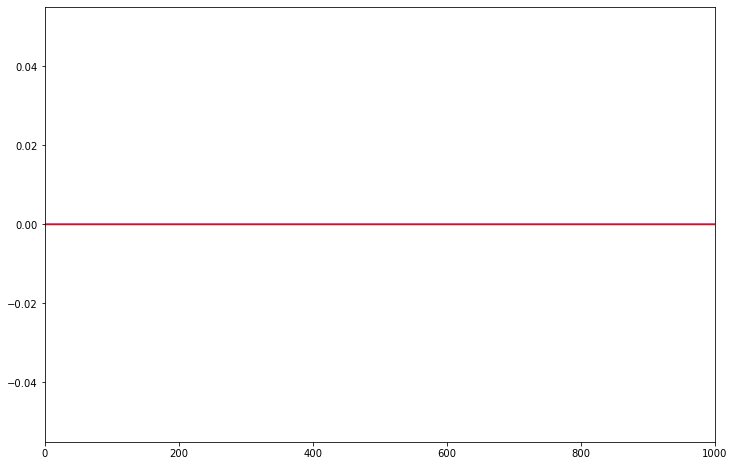

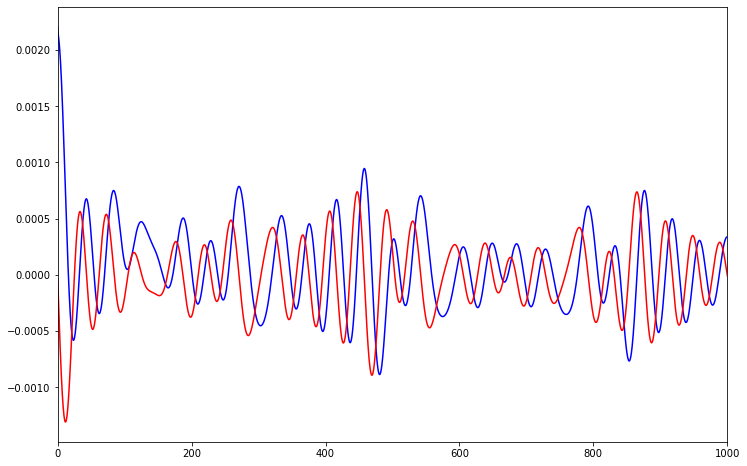

In [23]:


plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(cMMMM),"b")
plt.plot(time.data,np.imag(cMMMM),"r")
plt.plot(time.data,np.real(cfce.data)*1/2,"C0")
plt.plot(time.data,np.imag(cfce.data)*1/2,"C1")
plt.xlim(0,1000)

plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(np.exp(- gLLLL)),"b")
plt.plot(time.data,np.imag(np.exp(- gLLLL)),"r")
plt.xlim(0,10)

plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(np.exp(- gLLLL - gMMMM + 2*gMMLL)),"b")
plt.plot(time.data,np.imag(np.exp(- gLLLL - gMMMM + 2*gMMLL)),"r")
plt.xlim(0,10)

plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(cMMLL),"b")
plt.plot(time.data,np.imag(cMMLL),"r")
plt.xlim(0,1000)

plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(hMLLL- hMMML + 2*1j*lambdaMLLL),"b")
plt.plot(time.data,np.imag(hMLLL- hMMML + 2*1j*lambdaMLLL),"r")
plt.xlim(0,1000)

plt.figure(figsize=(12,8))
plt.plot(time.data,np.real(ft),"b")
plt.plot(time.data,np.imag(ft),"r")
plt.xlim(0,1000)

0.0152990151692
0.00919589004602


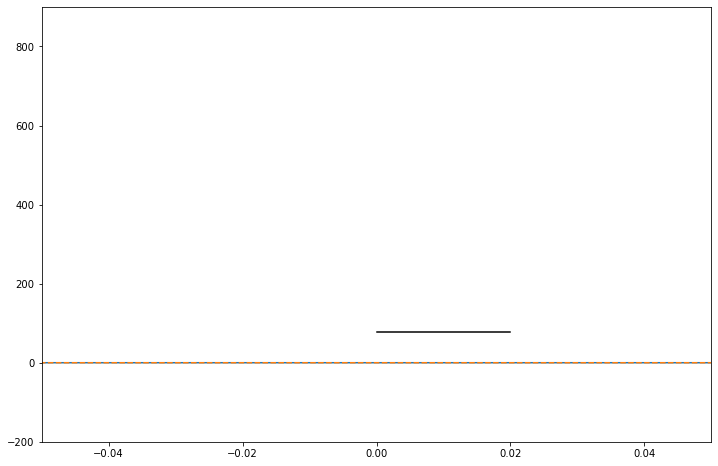

In [24]:
# Test of the fourier transform
Cw_even = cfce.get_EvenFTCorrelationFunction()
Cw_odd = cfce.get_OddFTCorrelationFunction()
Cw = Cw_even + Cw_odd

plt.figure(figsize=(12,8))
plt.plot(faxis.data,Cw.data*0.5,label="C(w) from quantarhei")
plt.plot(faxis.data,fw_full,"--",label="f(w) from redfield rates")
plt.plot([0,0.02],[78,78],"k")
plt.xlim([-0.05,0.05])
plt.ylim([-200,900])

print(Cw.at(0.02)*0.5)
print(Cw.at(-0.02)*0.5)

In [25]:
# Testing timing of different approaches

import time
start = time.perf_counter()
for k in range(10000):
    a = np.array([1,2,3])
    b = np.tile(a,(aggreg.sbi.TimeAxis._length,1)).T
    res = np.sum(b*Cmat,axis=0)
stop = time.perf_counter()
print(stop-start)

start = time.perf_counter()
for k in range(10000):
    res2 = np.zeros((aggreg.Ntot,aggreg.sbi.TimeAxis._length),dtype=np.complex128)
    for ii in range(aggreg.Ntot):
        res2[:] += a[ii]*Cmat[ii,:]
stop = time.perf_counter()
print(stop-start)

start = time.perf_counter()
for k in range(10000):
    res3 = np.dot(a,Cmat)
stop = time.perf_counter()
print(stop-start)

5.162271826993674
5.993944844987709
1.0915413500042632


In [26]:
time = aggreg.sbi.TimeAxis

# Test spectral density:
SDw = cfce.get_SpectralDensity()

SD_even = cfce.get_EvenFTCorrelationFunction()
SD_odd = cfce.get_OddFTCorrelationFunction()

cfce2 = cfce.copy()
cfce2.data = 1j*np.imag(cfce2.data)
SD2w = np.real(cfce2.get_Fourier_transform().data)


cf_full = np.zeros(time._length*2,dtype=np.complex128)
cf_full[time._length:] = 1j*np.imag(cfce.data)
cf_full[1:time._length] = np.conj(1j*np.imag(cfce.data[:0:-1]))



cf_full2 = np.zeros(time._length*2,dtype=np.complex128)
#cf_full2[:time._length] = cfce.data.copy()
cf_full2[time._length:] = cfce.data
cf_full2[1:time._length] = np.conj(cfce.data[:0:-1])



# Fourier transform
ft = np.fft.hfft(cf_full)*time.step
ft = np.fft.fftshift(ft)
# invert the order because hfft is a transform with -i
ft = np.flipud(ft)   
# cut the center of the spectrum
Nt = 2*time.length #len(ta.data)        
SDtest = ft[Nt//2:Nt+Nt//2]

#SDtest2 = 2*time.length*np.fft.fftshift(np.fft.ifft(cf_full2))*time.step
SDtest = 2*time.length*np.fft.fftshift(np.fft.ifft(np.fft.fftshift(cf_full)))*time.step
SDtest2 = 2*time.length*np.fft.fftshift(np.fft.ifft(np.fft.fftshift(cf_full2)))*time.step

In [27]:
SD2w

array([  2.97410208e-18,  -1.57685010e-09,  -2.58012062e-09, ...,
         3.58339118e-09,   2.58012062e-09,   1.57685009e-09])

In [28]:
cf_full

array([ 0. +0.00000000e+00j,  0. -8.15743064e-07j,  0. -1.62986071e-06j,
       ...,  0. +2.44073144e-06j,  0. +1.62986071e-06j,
        0. +8.15743064e-07j])

In [29]:
np.imag(SDtest)

array([ -1.91599734e-05,  -1.91599734e-05,  -1.91599734e-05, ...,
        -1.91599734e-05,  -1.91599734e-05,  -1.91599734e-05])

In [30]:
SDtest

array([  2.97410208e-18 -1.91599734e-05j,
        -1.57685010e-09 -1.91599734e-05j,
        -2.58012062e-09 -1.91599734e-05j, ...,
         3.58339118e-09 -1.91599734e-05j,
         2.58012062e-09 -1.91599734e-05j,   1.57685009e-09 -1.91599734e-05j])

In [31]:
SDw.data[time.length:]

array([  0.00000000e+00,   1.39354365e-03,   2.75572244e-03, ...,
         3.58339118e-09,   2.58012062e-09,   1.57685008e-09])

In [32]:
SD_odd = np.real(SDtest2[:])*0.5*(1-np.exp(-(SDw.axis.data[:]/kB_int/Temp)))
#SDtest2[time.length:]/(1+1/np.tanh((SDw.axis.data[time.length:]/kB_int/Temp*0.5)))
#SDtest[time.length:]/(1+1/np.tanh((SDw.axis.data[time.length:]/kB_int/Temp*0.5)))

/home/slamav/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/slamav/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


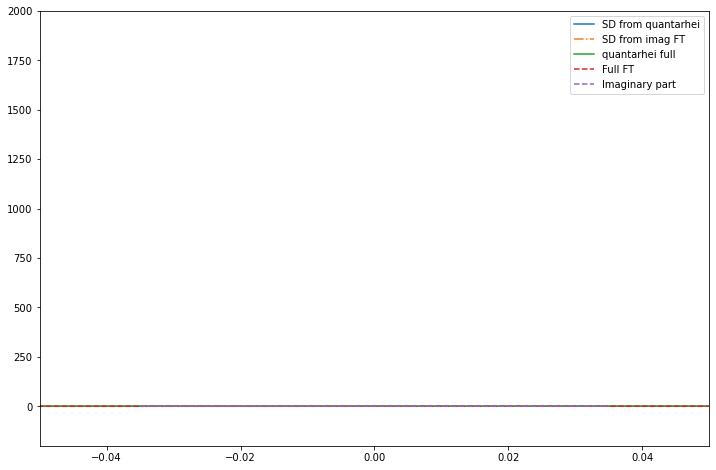

In [33]:


plt.figure(figsize=(12,8))
plt.plot(SDw.axis.data,SDw.data,label="SD from quantarhei")
#plt.plot(SDw.axis.data,SD2w,"--")
plt.plot(SDw.axis.data,SDtest,"-.",label="SD from imag FT")
plt.plot(SDw.axis.data,SD_even.data+SD_odd.data,label="quantarhei full")
plt.plot(SDw.axis.data,SDtest2,"--",label="Full FT")
plt.plot(SDw.axis.data[time.length-100:time.length+101],SD_odd[time.length-100:time.length+101],"--",label="Imaginary part")
plt.xlim([-0.05,0.05])
plt.ylim([-200,2000])
plt.legend()

In [34]:
print(SDw.axis.data[time.length+100])
print(SDw.axis.data[time.length-100])
# Check the detailed balance condition for the C(w)
print(np.real(SDtest2[time.length+100])/np.real(SDtest2[time.length-100]))
print(np.exp(SDw.axis.data[time.length+100]/kB_int/Temp))

0.0349065850392
-0.0349065850405
2.43306717705
2.43208452118


/home/slamav/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/slamav/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


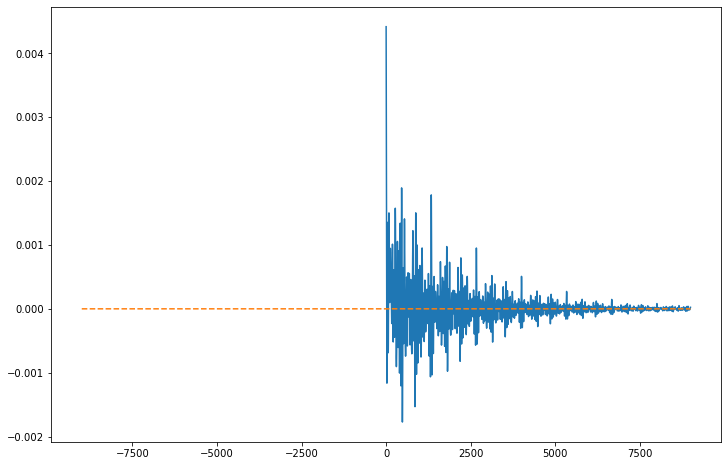

In [35]:
plt.figure(figsize=(12,8))
plt.plot(cfce.axis.data,cfce.data)
plt.plot(time_full,cf_full,"--")

In [36]:
ft[Nt//2:Nt+Nt//2].size

60000

In [37]:
SDw.axis.data.size

60000

In [38]:
cfce.axis.data.size

30000

In [39]:
time.get_FrequencyAxis().data.size

60000

In [40]:
aggreg.sbi.KK

array([[[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  1.]]])

In [41]:
from quantarhei.qm import RedfieldRelaxationTensor
from quantarhei.qm import RedfieldRateMatrix
from quantarhei.core.parallel import start_parallel_region, close_parallel_region
from quantarhei.qm.liouvillespace.Mockevolutionsuperoperator import MockEvolutionSuperOperator

In [42]:
start_parallel_region()
RT = RedfieldRelaxationTensor(Hop,aggreg.sbi,initialize=True,as_operators=True)
Rmat = RedfieldRateMatrix(Hop,aggreg.sbi)
close_parallel_region()
#MockEvolutionSuperOperator()


In [43]:
print(RT.Km)
print(SS[1,1]*SS[1,1],SS[1,1]*SS[1,2])
print(SS[1,2]*SS[1,1],SS[1,2]*SS[1,2])
print()
print(SS[2,1]*SS[2,1],SS[2,1]*SS[2,2])
print(SS[2,2]*SS[2,1],SS[2,2]*SS[2,2])

[[[ 0.   0.   0. ]
  [ 0.   0.5 -0.5]
  [ 0.  -0.5  0.5]]

 [[ 0.   0.   0. ]
  [ 0.   0.5  0.5]
  [ 0.   0.5  0.5]]]
0.5 -0.5
-0.5 0.5

0.5 0.5
0.5 0.5


In [44]:
print(RT.Lm)

[[[ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j        ]
  [ 0.00000000+0.j          0.07869335-0.01884312j -0.00772743-0.0013374j ]
  [ 0.00000000+0.j         -0.00453300+0.03061134j  0.07869335-0.01884312j]]

 [[ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j        ]
  [ 0.00000000+0.j          0.07869335-0.01884312j  0.00772743+0.0013374j ]
  [ 0.00000000+0.j          0.00453300-0.03061134j  0.07869335-0.01884312j]]]


In [45]:
Rmat.data

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00919338,  0.01529764],
       [ 0.        ,  0.00919338, -0.01529764]])

In [46]:
mRedRates.rates

array([[-0.        ,  0.        ,  0.        ],
       [ 0.        , -0.0091942 ,  0.01529902],
       [ 0.        ,  0.0091942 , -0.01529902]])

In [47]:
start_parallel_region()
RT.convert_2_tensor()
close_parallel_region()
print(RT.data[1,1,2,2])
print(RT.data[2,2,1,1])

(0.0154548577041+0j)
(0.00906600214109+0j)


In [48]:
Hop.data

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.01],
       [ 0.  ,  0.01,  1.  ]])

In [49]:
np.dot(aggreg.SS.T,aggreg.SS)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])